In [2]:
# module to access PostgreSQL databases
import psycopg2
# matplotlib pyplot module
import matplotlib.pyplot as plt

# connect to UDD database
conn = psycopg2.connect(database="udd")
# prepare a cursor
cur = conn.cursor()

# this is the query we'll be making
query = """
select to_char(date AT TIME ZONE 'UTC', 'HH24'), count(*)
  from upload_history
 where to_char(date, 'YYYY') = '2008'
 group by 1
 order by 1"""

# execute the query
cur.execute(query)

# retrieve the whole result set
data = cur.fetchall()

# close cursor and connection
cur.close()
conn.close()

# unpack data in hours (first column) and 
# uploads (second column)
hours, uploads = zip(*data)

# graph code
plt.plot(hours, uploads)
# the the x limits to the 'hours' limit
plt.xlim(0, 23)
# set the X ticks every 2 hours
plt.xticks(range(0, 23, 2))
# draw a grid
plt.grid()
# set title, X/Y labels
plt.title("Debian packages uploads per hour in 2008")
plt.xlabel("Hour (in UTC)")
plt.ylabel("No. of uploads")

# adjust before plotting
plt.subplots_adjust(bottom=0.13, left=0.16)

# save & show the plot
plt.savefig('7900_09_01.png')
plt.show()

OperationalError: could not connect to server: Connection refused (0x0000274D/10061)
	Is the server running on host "localhost" (::1) and accepting
	TCP/IP connections on port 5432?
could not connect to server: Connection refused (0x0000274D/10061)
	Is the server running on host "localhost" (127.0.0.1) and accepting
	TCP/IP connections on port 5432?


In [3]:
# to get the web pages
import urllib2

# lxml submodule for html parsing
from lxml.html import parse

# regular expression module
import re

# Matplotlib module
import matplotlib.pyplot as plt

# general urllib2 config
user_agent = 'Mozilla/5.0 (compatible; MSIE 5.5; Windows NT)'
headers = { 'User-Agent' : user_agent }
url = "http://it.wikipedia.org/wiki/Demografia_d'Italia"

# prepare the request and open the url
req = urllib2.Request(url, headers=headers)
response = urllib2.urlopen(req)

# we parse the webpage, getroot() return the document root
doc = parse(response).getroot()

# find the data table, using css elements
table = doc.cssselect('table.wikitable')[0]

# prepare data structures, will contain actual data
years = []
people = []

# iterate over the rows of the table, except first and last ones
for row in table.cssselect('tr')[1:-1]:
    # get the row cell (we will use only the first two)
    data = row.cssselect('td')

    # the first cell is the year
    tmp_years = data[0].text_content()
    # cleanup for cases like 'YYYY[N]' (date + footnote link)
    tmp_years = re.sub('\[.\]', '', tmp_years)

    # the second cell is the population count
    tmp_people = data[1].text_content()
    # cleanup from '.', used as separator
    tmp_people = tmp_people.replace('.', '')

    # append current data to data lists, converting to integers
    years.append(int(tmp_years))
    people.append(int(tmp_people))

# plot data
plt.plot(years,people)
# ticks every 10 years
plt.xticks(range(min(years), max(years), 10))
plt.grid()
# add a note for 2001 Census
plt.annotate("2001 Census", xy=(2001, people[years.index(2001)]),
             xytext=(1986, 54.5*10**6),
             arrowprops=dict(arrowstyle='fancy'))

plt.savefig('7900_09_02.png')
plt.show()

ImportError: No module named 'urllib2'

In [4]:
# to read Apache log file
from __future__ import with_statement
# Numpy and matplotlib modules
import numpy as np
import matplotlib.pyplot as plt
# needed for formatting Y axis
from matplotlib.ticker import FuncFormatter
# to parse the log file
import re

def megabytes(x, pos):
    """Formatter for Y axis, values are in megabytes"""
    return '%1.f' % (x/(1024*1024))

# prepare the regular expression to match
# the day and the size of the request
apa_line = re.compile(r'.*\[([^:]+):.* ([0-9]+) .+ .+')

# prepare dictionaries to contain the data
day_hits = {}
day_txn = {}

# we open the file
with open('/var/log/apache2/access.log') as f:
    # and for every line in it
    for line in f:
        # we pass the line to regular expression
        m = apa_line.match(line)
        # and we get the 2 values matched back
        day, call_size = m.groups()

        # if the current day is already present
        if day in day_hits:
            # we add the call and the size of the request
            day_hits[day] += 1
            day_txn[day] += int(call_size)
        else:
            # else we initialize the dictionaries
            day_hits[day] = 1
            day_txn[day] = int(call_size)

# prepare a list of the keys (days)
keys = sorted(day_hits.keys())

# prepare a figure and an Axes in it
fig = plt.figure()
ax1 = fig.add_subplot(111)

# bar width
width = .4

# for each key (day) and it's position
for i, k  in enumerate(keys):
    # we plot a bar
    ax1.bar(i - width/2, day_hits[k], width=width, color='y')

# for each label for the X ticks
for label in ax1.get_xticklabels():
    # we hide it
    label.set_visible(False)

# add a label to the Y axis (for the first plot)
ax1.set_ylabel('Total hits')

# create another Axes instance, twin of the previous one
ax2 = ax1.twinx()

# plot the total requests size
ax2.plot([day_txn[k] for k in keys], 'k', linewidth=2)

# set the Y axis to start from 0
ax2.set_ylim(ymin=0)

# set the X ticks for each element of keys (days)
ax2.set_xticks(range(len(keys)))
# set the label for them to keys, rotating and align to the right
ax2.set_xticklabels(keys, rotation=25, ha='right')

# set the formatter for Y ticks labels
ax2.yaxis.set_major_formatter(FuncFormatter(megabytes))
# add a label to Y axis (for the second plot)
ax2.set_ylabel('Total transferred data (in Mb)')

# add a title to the whole plot
plt.title('Apache hits and transferred data by day')

# save & show the figure
plt.subplots_adjust(bottom=0.18)
plt.savefig('7900_09_03.png')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/var/log/apache2/access.log'

In [5]:
# for file opening made easier
from __future__ import with_statement
# numpy
import numpy as np
# matplotlib plotting module
import matplotlib.pyplot as plt
# matplotlib colormap module
import matplotlib.cm as cm
# needed for formatting Y axis
from matplotlib.ticker import FuncFormatter
# Matplotlib font manager
import matplotlib.font_manager as font_manager


def billions(x, pos):
    """Formatter for Y axis, values are in billions"""
    return '%1.fbn' % (x*1e-6)

# bar width
width = .8

# open CSV file
with open('../data/population.csv') as f:
    # read the first line, splitting the years
    years = map(int, f.readline().split(',')[1:])

    # we prepare the dtype for exacting data; it's made of:
    # <1 string field> <len(years) integers fields>
    dtype = [('continents', 'S16')] + [('', np.int32)]*len(years)

    # we load the file, setting the delimiter and the dtype above
    y = np.loadtxt(f, delimiter=',', dtype=dtype)

    # "map" the resulting structure to be easily accessible:
    # the first column (made of string) is called 'continents'
    # the remaining values are added to 'data' sub-matrix
    # where the real data are
    y = y.view(np.dtype([('continents', 'S16'),
                         ('data', np.int32, len(years))]))

# extract fields
data = y['data']
continents = y['continents']

# prepare the bottom array
bottom = np.zeros(len(years))

# for each line in data
for i in range(len(data)):
    # create the bars for each element, on top of the previous bars
    bt = plt.bar(range(len(data[i])), data[i], width=width,
                 color=cm.hsv(32*(i)), label=continents[i],
                 bottom=bottom)
    # update the bottom array
    bottom += data[i]

# label the X ticks with years
plt.xticks(np.arange(len(years))+width/2,
           [int(year) for year in years])

# some information on the plot
plt.xlabel('Years')
plt.ylabel('Population (in billions)')
plt.title('World Population: 1950 - 2050 (predictions)')

# draw a legend, with a smaller font
plt.legend(loc='upper left',
           prop=font_manager.FontProperties(size=7))

# apply the custom function as Y axis formatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions))

plt.subplots_adjust(bottom=0.11, left=0.15)
plt.savefig('7900_09_04.png')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/population.csv'

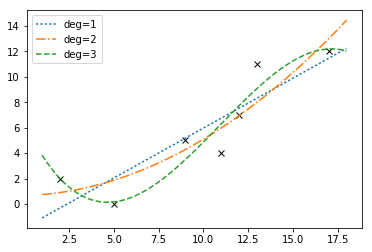

In [6]:
# Numpy and Matplotlib
import numpy as np
import matplotlib.pyplot as plt

# the known points set
data = [[2,2],[5,0],[9,5],[11,4],[12,7],[13,11],[17,12]]

# we extract the X and Y components from previous points
x, y = zip(*data)

# plot the data points with a black cross
plt.plot(x, y, 'kx')

# we want a bit more data and more fine grained for
# the fitting functions
x2 = np.arange(min(x)-1, max(x)+1, .01)

# lines styles for the polynomials
styles = [':', '-.', '--']

# getting style and count one at time
for d, style in enumerate(styles):
    # degree of the polynomial
    deg = d + 1
    # calculate the coefficients of the fitting polynomial
    c = np.polyfit(x, y, deg)
    # we evaluate the fitting function against x2
    y2 = np.polyval(c, x2)
    # and then we plot it, label is the polynomial degree
    # and the line style is selected from the list
    plt.plot(x2, y2, label="deg=%d" % deg, linestyle=style)

# show the legend
plt.legend(loc='upper left')

# show the plot
plt.savefig('7900_09_05.png')
plt.show()

In [7]:
# for file opening made easier
from __future__ import with_statement
# numpy
import numpy as np
# matplotlib plotting module
import matplotlib.pyplot as plt
# matplotlib colormap module
import matplotlib.cm as cm
# Matplotlib font manager
import matplotlib.font_manager as font_manager

# bar width
width = .8

# open CSV file
with open('../data/population.csv') as f:
    # read the first line, splitting the years
    years = map(int, f.readline().split(',')[1:])

    # we prepare the dtype for exacting data; it's made of:
    # <1 string field> <6 integers fields>
    dtype = [('continents', 'S16')] + [('', np.int32)]*len(years)

    # we load the file, setting the delimiter and the dtype above
    y = np.loadtxt(f, delimiter=',', dtype=dtype)

    # "map" the resulting structure to be easily accessible:
    # the first column (made of string) is called 'continents'
    # the remaining values are added to 'data' sub-matrix
    # where the real data are
    y = y.view(np.dtype([('continents', 'S16'),
                         ('data', np.int32, len(years))]))

# extract fields
data = y['data']
continents = y['continents']

x = years[:-2]
x2 = years[-2:]

# prepare the bottom array
b1 = np.zeros(len(years)-2)


# for each line in data
for i in range(len(data)):
    # select all the data except the last 2 values
    d = data[i][:-2]
    # create bars for each element, on top of the previous bars
    bt = plt.bar(range(len(d)), d, width=width,
                 color=cm.hsv(32*(i)), label=continents[i],
                 bottom=b1)
    # update the bottom array
    b1 += d

# prepare the bottom array
b2_1, b2_2 = np.zeros(2), np.zeros(2)

# for each line in data
for i in range(len(data)):
    # extract the last 2 values
    d = data[i][-2:]
    # select the data to compute the fitting function
    y = data[i][:-2]
    # use a polynomial of degree 3
    c = np.polyfit(x, y, 3)
    # create a function out of those coefficients
    p = np.poly1d(c)
    # compute p on x2 values (we need integers, so the map)
    y2 = map(int, p(x2))
    # create the bars for each element, on top of the previous bars
    bt = plt.bar(len(b1)+np.arange(len(d)), d, width=width/2,
                 color=cm.hsv(32*(i)), bottom=b2_1)
    # create bars for the extrapolated values
    bt = plt.bar(len(b1)+np.arange(len(d))+width/2, y2,
                 width=width/2, color=cm.bone(32*(i+2)),
                 bottom=b2_2)
    # update the bottom array
    b2_1 += d
    b2_2 += y2

# label the X ticks with years
plt.xticks(np.arange(len(years))+width/2,
           [int(year) for year in years])

# draw a legend, with a smaller font
plt.legend(loc='upper left',
           prop=font_manager.FontProperties(size=7))

# save & show the graph
plt.subplots_adjust(bottom=0.11, left=0.15)
plt.savefig('7900_09_06.png')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/population.csv'

In [8]:
# numpy
import numpy as np
# matplotlib
import matplotlib.pyplot as plt
# networkx nodule
import networkx as nx

# prepare a random graph with n nodes and m edges
n = 16
m = 60
G = nx.gnm_random_graph(n, m)

# prepare a circular layout of nodes
pos = nx.circular_layout(G)
# define the color to select from the color map
# as n numbers evenly spaced between color map limits
node_color = map(int, np.linspace(0, 255, n))

# draw the nodes, specifying the color map and the list of color
# to access it
nx.draw_networkx_nodes(G, pos,
                       node_color=node_color, cmap=plt.cm.hsv) 
# add the labels inside the nodes
nx.draw_networkx_labels(G, pos)
# draw the edges, using alpha parameter to make them lighter
nx.draw_networkx_edges(G, pos, alpha=0.4)

# turn off axis elements
plt.axis('off')

# show the resulting plot
plt.savefig('7900_09_07.png')
plt.show()

TypeError: float() argument must be a string or a number, not 'map'

In [9]:
# import mpmath module
import mpmath as mp

# trick to show & save with the same function:
# if file is None, it shows the plot, else it saves to the filename
for file in [None, '7900_09_08.png']:
    # plot a sine between -6 and 6
    mp.plot(mp.sin, [-6, 6], file=file)

# same trick as above
for file in [None, '7900_09_09.png']:
    # plot square root (to show complex plotting)
    # and a custom function (made with lambda expression)
    mp.plot([mp.sqrt, lambda x: -0.1*x**3 + x-0.5], [-3, 3],
            file=file)

ImportError: No module named 'mpmath'

In [10]:
# pyplot module import
import matplotlib.pyplot as plt
# basemap import
from mpl_toolkits.basemap import Basemap
# Numpy import
import numpy as np

plt.figure(1)

# Lambert Conformal map of USA lower 48 states
m = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64,
            urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
            lon_0=-95, resolution='h', area_thresh=10000)

# draw the coastlines of continental area
m.drawcoastlines()
# draw country boundaries
m.drawcountries(linewidth=2)
# draw states boundaries (America only)
m.drawstates()

# fill the background (the oceans)
m.drawmapboundary(fill_color='aqua')
# fill the continental area
# we color the lakes like the oceans
m.fillcontinents(color='coral',lake_color='aqua')

# draw parallels and meridians
m.drawparallels(np.arange(25,65,20),labels=[1,0,0,0])
m.drawmeridians(np.arange(-120,-40,20),labels=[0,0,0,1])

plt.title('United States of America (lower 48 states)')

plt.savefig('7900_09_10.png')

plt.figure(2)

m = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64,
            urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
            lon_0=-95, resolution='h', area_thresh=10000)

# display blue marble image (from NASA) as map background
m.bluemarble()

# draw the coastlines of continental area
m.drawcoastlines()
# draw country boundaries
m.drawcountries(linewidth=2)
# draw states boundaries (America only)
m.drawstates()

plt.title('USA and surroundings (Blue Marble maps)')

plt.savefig('7900_09_11.png')
plt.show()

ImportError: No module named 'mpl_toolkits.basemap'